# CatBoost

In [1]:
import optuna
from utils.preprocessing import *
from utils.visualization import *
from utils.trainer import *
from utils.config import *
from utils.helpers import *

In [2]:
model_name       = 'catboost'
best_params_path = paths[model_name]['best_params']
model_path_list  = paths[model_name]['models']
pred_5folds_path = paths[model_name]['pred_5folds']
shap_fi_path     = paths[model_name]['shap_fi']

## 1. Load data

In [3]:
# Get lists of data by folds
X_train_list = [pd.read_csv(path) for path in X_train_paths]
y_train_list = [pd.read_csv(path) for path in y_train_paths]
y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]

X_val_list   = [pd.read_csv(path) for path in X_val_paths]
y_val_list   = [pd.read_csv(path) for path in y_val_paths]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

## 2. Hyperparameters Tuning

In [4]:
def objective(trial):    
    param = {
        'iterations'           : trial.suggest_int('iterations', 500, 2000),
        'depth'                : trial.suggest_int('depth', 2, 9),
        'learning_rate'        : trial.suggest_float('learning_rate', 0.1, 0.9),
        'random_strength'      : trial.suggest_int('random_strength', 10, 20),
        'bagging_temperature'  : trial.suggest_float('bagging_temperature', 0.0, 0.5),
        'border_count'         : trial.suggest_int('border_count', 512, 2048),
        'l2_leaf_reg'          : trial.suggest_int('l2_leaf_reg', 2, 30),
        'loss_function'        : 'Logloss',
        'eval_metric'          : 'AUC',
        'random_seed'          : RANDOM_STATE,
        'verbose'              : False,
    }
    
    trainer = CatBoostTrainer(model=CatBoostClassifier(**param))
    mean_metrics, *_ = trainer.perform_cross_validation(
        X_train_list, y_train_list,
        X_val_list, y_val_list,
        verbose=0
    )
    avg = (mean_metrics.get('mean_accuracy') + mean_metrics.get('mean_f1_score') + mean_metrics.get('mean_roc_auc')) / 3
    return avg

In [5]:
HP_TUNING = False
if HP_TUNING:
    direction = 'maximize'
    n_trials  = 500
    n_jobs    = -1
    
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    best_params = study.best_trial.params
    best_params.update({
        'loss_function': 'Logloss',
        'eval_metric'  : 'AUC',
        'random_seed'  : RANDOM_STATE,
        'verbose'      : False,
    })
else:
    best_params = load_json(best_params_path)
    
best_params

{'iterations': 1462,
 'depth': 6,
 'learning_rate': 0.4854761821403504,
 'random_strength': 12,
 'bagging_temperature': 0.3456894298321191,
 'border_count': 1244,
 'l2_leaf_reg': 19,
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'random_seed': 42,
 'verbose': False}

## 3. Train with 5-fold cross validation

In [6]:
trainer = CatBoostTrainer(model=CatBoostClassifier(**best_params))
mean_metrics, y_pred_list, y_pred_proba_list, fi_list = trainer.perform_cross_validation(
    X_train_list=X_train_list,
    y_train_list=y_train_list,
    X_val_list=X_val_list,
    y_val_list=y_val_list,
    #model_path_list=model_path_list, # uncomment if you want to save newly trained models
    verbose=1,
)

Fold 1/5:


	- ACCURACY: 0.8545
	- ROC_AUC: 0.8987
	- F1_SCORE: 0.8333
	- MSE: 0.1333
	- PRECISION: 0.8696
	- RECALL: 0.8000
	- SPECIFICITY: 0.9000

Fold 2/5:
	- ACCURACY: 0.8909
	- ROC_AUC: 0.9520
	- F1_SCORE: 0.8846
	- MSE: 0.0812
	- PRECISION: 0.8519
	- RECALL: 0.9200
	- SPECIFICITY: 0.8667

Fold 3/5:
	- ACCURACY: 0.9091
	- ROC_AUC: 0.9467
	- F1_SCORE: 0.8980
	- MSE: 0.1054
	- PRECISION: 0.9167
	- RECALL: 0.8800
	- SPECIFICITY: 0.9333

Fold 4/5:
	- ACCURACY: 0.8704
	- ROC_AUC: 0.9241
	- F1_SCORE: 0.8679
	- MSE: 0.1016
	- PRECISION: 0.8214
	- RECALL: 0.9200
	- SPECIFICITY: 0.8276

Fold 5/5:
	- ACCURACY: 0.8704
	- ROC_AUC: 0.9476
	- F1_SCORE: 0.8511
	- MSE: 0.1011
	- PRECISION: 0.9091
	- RECALL: 0.8000
	- SPECIFICITY: 0.9310

------------------------------
	- MEAN MEAN_ACCURACY: 0.8791
	- MEAN MEAN_ROC_AUC: 0.9338
	- MEAN MEAN_F1_SCORE: 0.8670
	- MEAN MEAN_MSE: 0.1045
	- MEAN MEAN_PRECISION: 0.8737
	- MEAN MEAN_RECALL: 0.8640
	- MEAN MEAN_SPECIFICITY: 0.8917


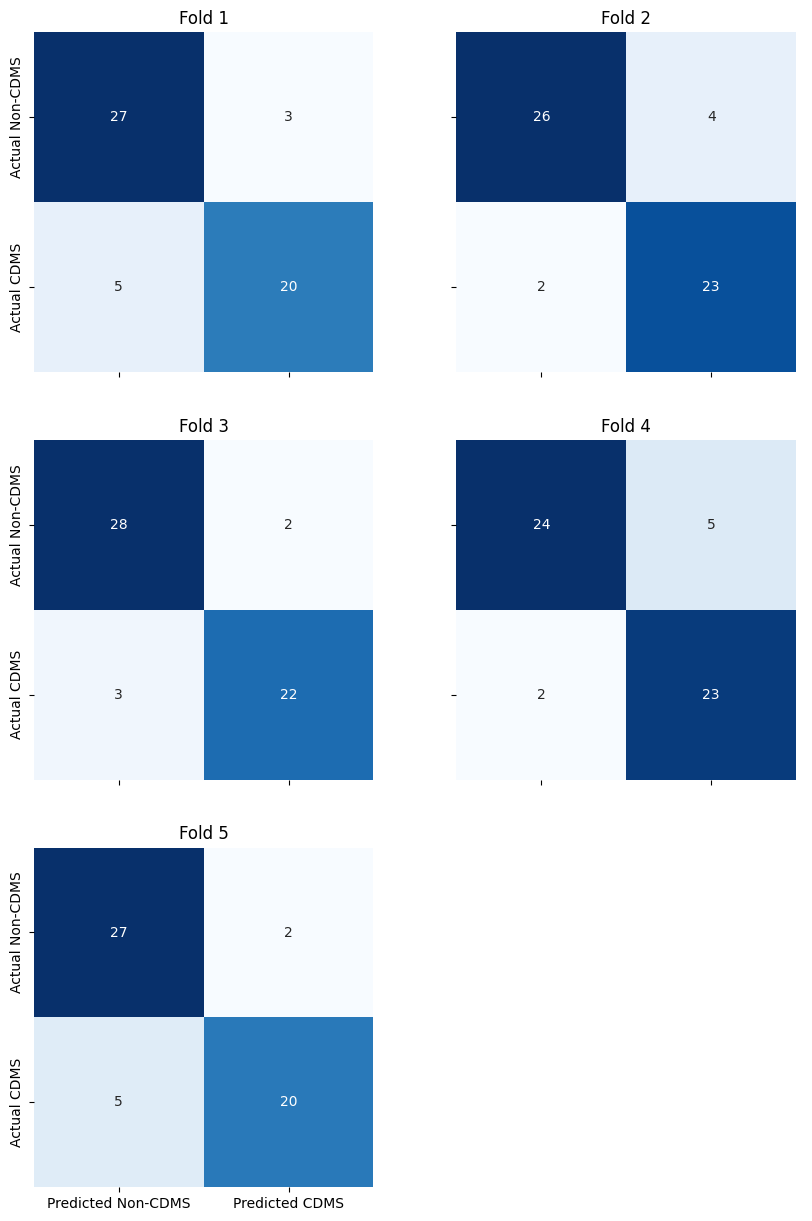

In [7]:
plot_confusion_matrix_folds(
    y_test_list=y_val_list,
    y_pred_list=y_pred_list
)

## 4. Feature Importance

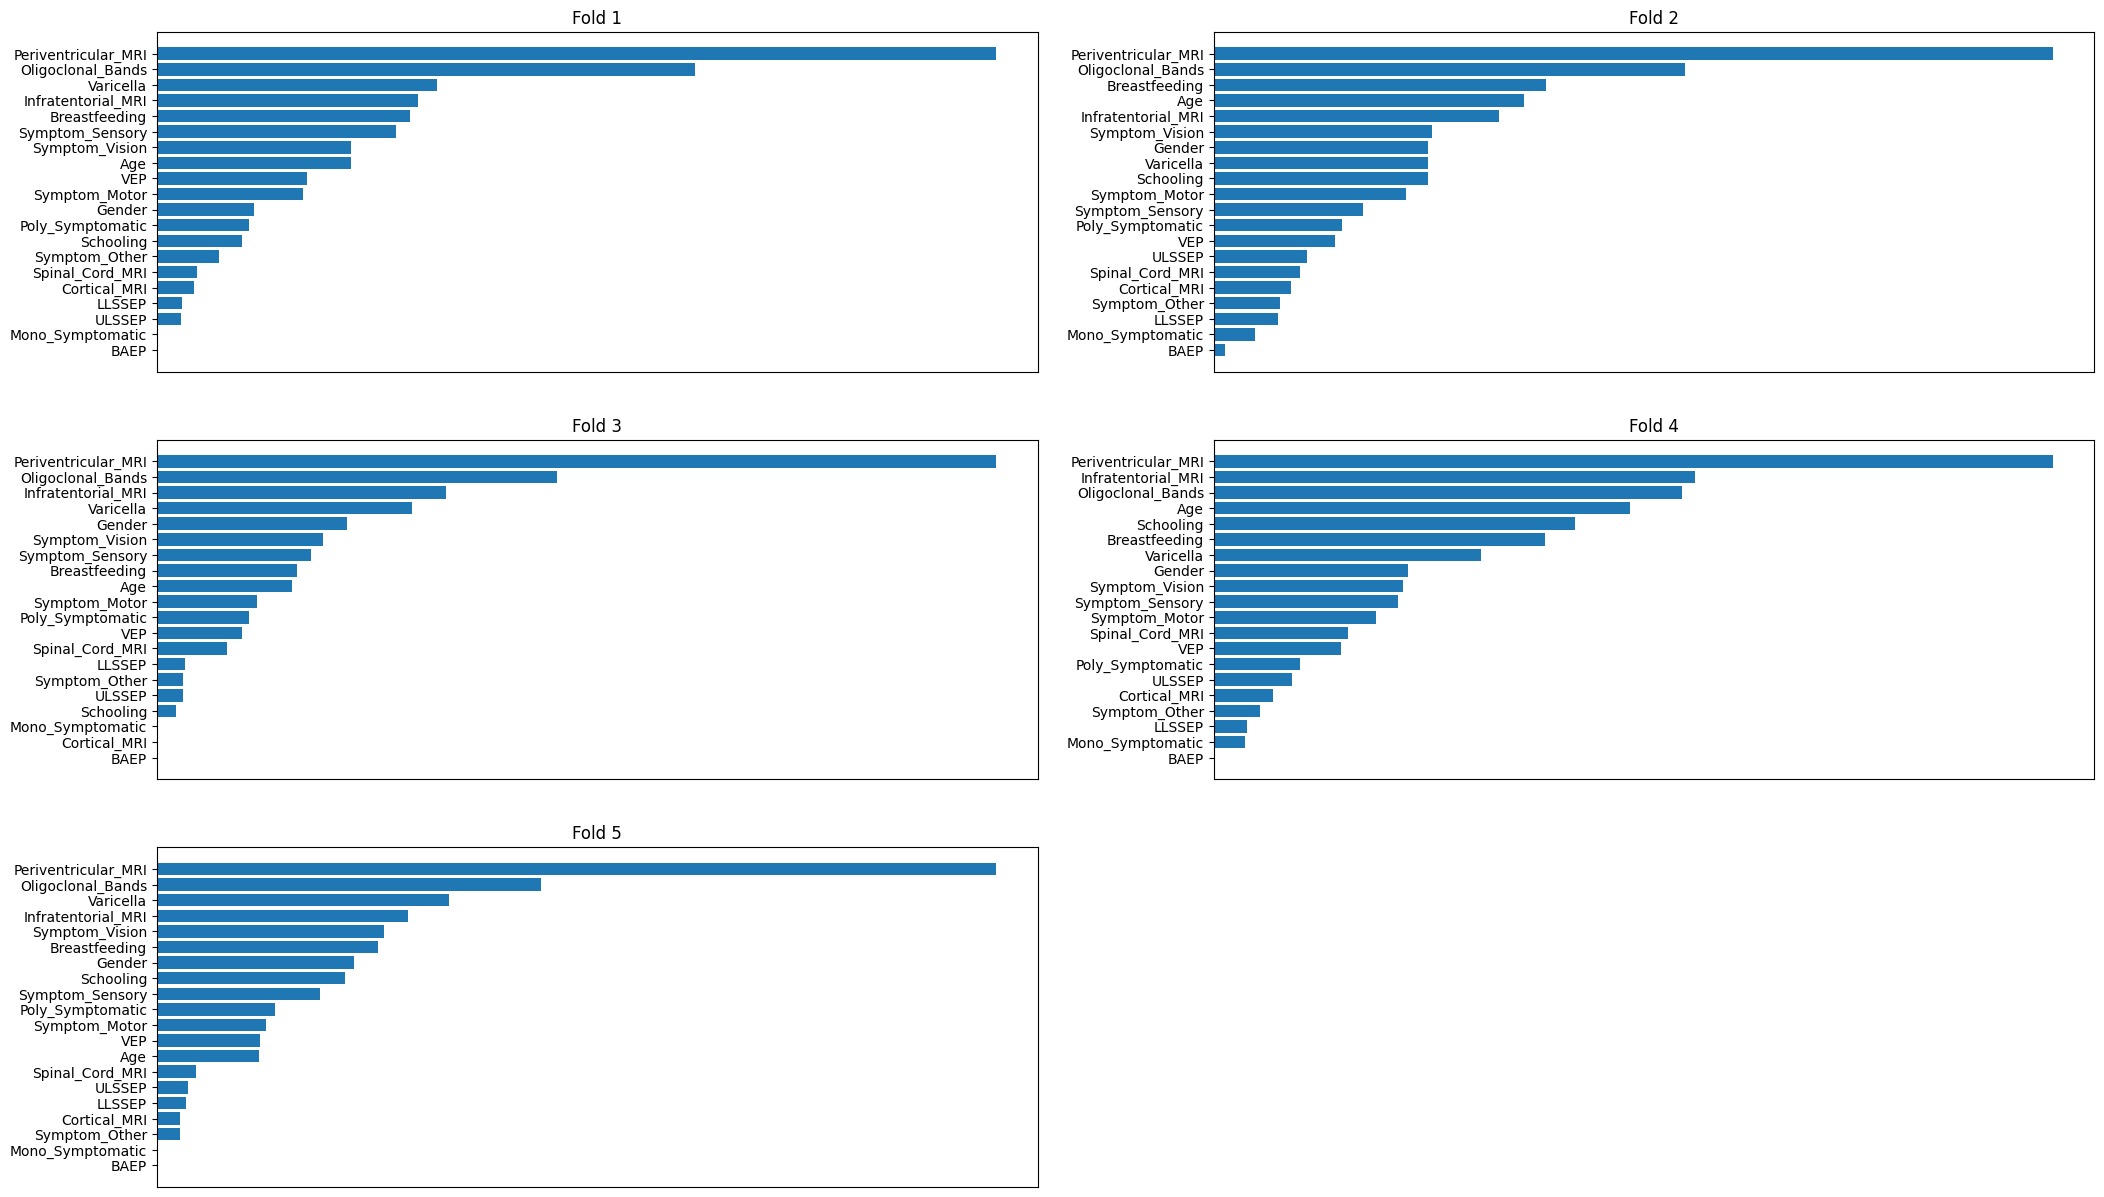

In [8]:
plot_catboost_feature_importance_folds(
    fi_list=fi_list,
    columns_folds=[X_train.columns for X_train in X_train_list])

In [9]:
fi_dfs = []
for fi, X_train_fold in zip(fi_list, X_train_list):
    fi_df = pd.DataFrame({'Feature Id': X_train_fold.columns, 'Importances': fi})
    fi_dfs.append(fi_df)

feature_importance = average_feature_importances(fi_dfs)
#feature_importance.to_csv('data/catboost/feature_importance.csv', index=False)
feature_importance

,Feature Id,Importances
0,Periventricular_MRI,23.103225
1,Oligoclonal_Bands,12.355036
2,Infratentorial_MRI,8.414949
3,Varicella,7.245170
4,Breastfeeding,6.758365
5,Age,5.953355
6,Symptom_Vision,5.457317
7,Gender,4.888860
8,Symptom_Sensory,4.886956
9,Schooling,4.380413


## 5. Get predictions for all folds

In [10]:
analyzed_dfs = []

for fold in range(1, 6):
    # Load data for the current fold
    X_train, y_train, X_val, y_val = load_data_fold(fold)

    # Load trained model for the current fold
    model = load_model_fold(fold, model_name=model_name)

    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,-1]

    # Add ground truths and predictions to the current df
    analyzed_df = X_val.copy()
    analyzed_df['Actual'] = y_val
    analyzed_df['Predicted'] = y_pred
    analyzed_df['Predicted_Proba'] = y_pred_proba
    analyzed_dfs.append(analyzed_df)

analyzed_df_aggregated = pd.concat(analyzed_dfs, axis=0).reset_index(drop=True)
print(f'analyzed_df_aggregated.shape: {analyzed_df_aggregated.shape}')

# analyzed_df_aggregated.to_csv(pred_5folds_path, index=False)
# print(f'Save df to {pred_5folds_path}')

analyzed_df_aggregated.shape: (273, 23)


## 6. Explain with SHAP

In [11]:
import shap

models = [load_model_fold(fold+1, model_name) for fold in range(5)]
shap_values_folds = []
interaction_values = []

for fold in range(5):
    model = models[fold]
    X_val = X_val_list[fold]

    # Explainer
    explainer = shap.TreeExplainer(model)

    # SHAP values
    sv = explainer.shap_values(X_val)
    mean_sv = np.mean(np.abs(sv), axis=0)
    shap_values_folds.append(mean_sv)

    # SHAP interaction values
    iv = explainer.shap_interaction_values(X_val)
    mean_iv = np.mean(np.abs(iv), axis=0)
    interaction_values.append(mean_iv)

# Aggregate SHAP values across folds
aggregated_shap_values = np.mean(shap_values_folds, axis=0)
aggregated_interaction_values = np.mean(interaction_values, axis=0)

# Calculate mean absolute SHAP values for feature importance
feature_names = X_val_list[0].columns.to_list()
shap_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': aggregated_shap_values
})

# Sort by importance
shap_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
#shap_feature_importance.to_csv(shap_fi_path, index=False)
shap_feature_importance

,Feature,Importance
10,Periventricular_MRI,1.145402
5,Oligoclonal_Bands,0.712060
12,Infratentorial_MRI,0.499978
3,Breastfeeding,0.357245
2,Schooling,0.334608
16,Symptom_Motor,0.241213
0,Gender,0.229534
4,Varicella,0.206334
1,Age,0.196218
15,Symptom_Sensory,0.183305


<Axes: xlabel='Feature'>

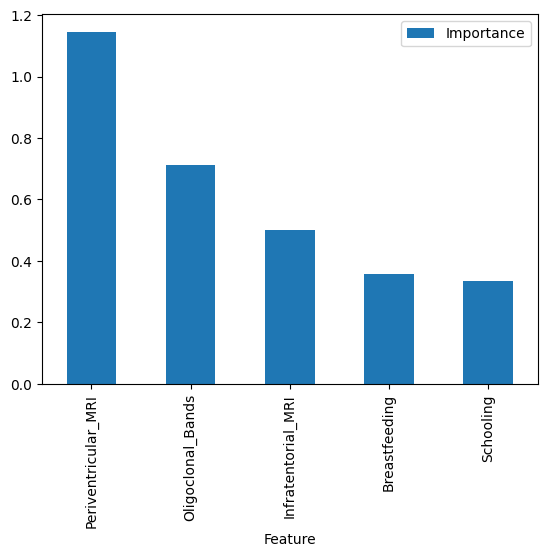

In [12]:
shap_feature_importance = shap_feature_importance.set_index('Feature')
shap_feature_importance.iloc[:5].plot(kind='bar')

<Axes: >

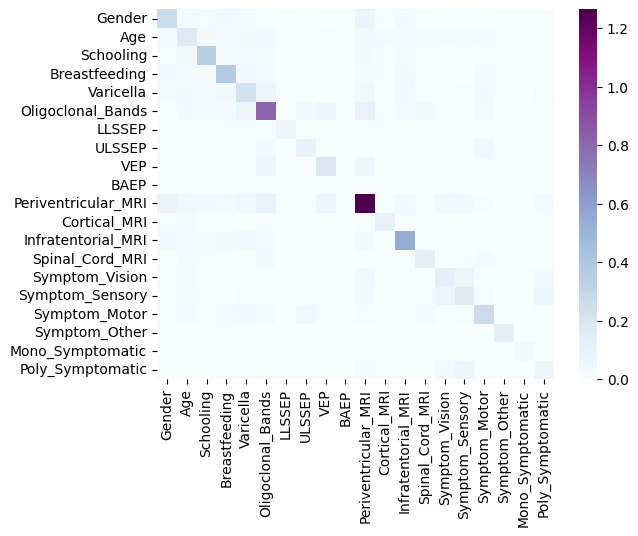

In [13]:
import seaborn as sns

sns.heatmap(
    aggregated_interaction_values,
    xticklabels=feature_names,
    yticklabels=feature_names,
    cmap='BuPu'
)